In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import imageio
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import Video

In [2]:
EPS_NUM = 600

### ENV Creation

In [3]:
env = gym.make('Acrobot-v1',render_mode='rgb_array')
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]

### DQ Network

In [4]:
class DQN_Network(nn.Module):
    def __init__(self, state_dim , action_dim):
        super(DQN_Network, self).__init__()
        self.x_layer = nn.Linear(state_dim, 50)
        self.h_layer = nn.Linear(50, 30)
        self.y_layer = nn.Linear(30, action_dim)
        print(self.x_layer)

    def forward(self, state):
        xh = F.relu(self.x_layer(state))
        hh = F.relu(self.h_layer(xh))
        state_action_values = self.y_layer(hh)
        return state_action_values

### DDQ Network

In [5]:
class DuelingDQN(nn.Module):

    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.input_dim = state_dim
        self.output_dim = action_dim
        
        self.feauture_layer = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.output_dim)
        )

    def forward(self, state):
        features = self.feauture_layer(state)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())
        
        return qvals

### Agent

In [6]:
class Q_agent():
    def __init__(self,s_size,a_size,method):
        if method == "DQN":
            self.net = DQN_Network(s_size,a_size)
        elif method == "DDQN":
            self.net = DuelingDQN(s_size,a_size)
        self.s_size = s_size
        self.a_size = a_size
        self.buffer = []
        self.loss = nn.MSELoss()
        self.batch_size = 64
        self.qnet_optim = torch.optim.Adam(self.net.parameters(), lr=0.001)
        


    def take_action(self,state,epsilon):
        prob = np.random.uniform(0,1)
        if prob<epsilon:
            return env.action_space.sample()

        else:
            state = torch.from_numpy(state).float()
            q_values = self.net(state).data.numpy()
            return np.argmax(q_values)
    
    def fill_buffer(self,data):
        self.buffer.append(data)

    def unpack(self,sample_batch):
        states = np.zeros((len(sample_batch),self.s_size))
        next_states = np.zeros((len(sample_batch),self.s_size))
        rewards = []
        actions = []
        termins = []
        for i,(state,action,reward,next_state,terminated) in enumerate(sample_batch):
            states[i,:] = state
            next_states[i,:] = next_state
            rewards.append(reward)
            actions.append(action)
            termins.append(terminated)
        return torch.tensor(states),torch.tensor(next_states),torch.tensor(rewards).view(-1,1),torch.tensor(actions),torch.tensor(termins).view(-1,1)
    
    def update_net(self,states,next_states,rewards,actions,termins):
        
        
        qsa_current = torch.gather((self.net(states.float())),dim= 1,index = actions.view(-1,1).long())

        qsa_next_states = self.net(next_states.float())
        qsa_next_states,_ = torch.max(qsa_next_states,dim=1,keepdim=True)

        qsa_target = rewards +  (1-termins.int())*0.99*qsa_next_states

        q_network_loss = self.loss(qsa_current, qsa_target.detach())

        self.qnet_optim.zero_grad()
        q_network_loss.backward()
        self.qnet_optim.step()

    def train(self,update_rate):
        for i in range(update_rate):
            sample_batch = random.sample(self.buffer,self.batch_size)
            states,next_states,rewards,actions,termins = self.unpack(sample_batch)
            self.update_net(states,next_states,rewards,actions,termins)

    def best(self):
        state = env.reset()[0]
        terminal = False
        self.images = []
        while not terminal:
            action = np.argmax(self.net(torch.from_numpy(state).float()).data.numpy())
            next_state, _, terminated,truncated, _ = env.step(action)
            terminal = terminated or truncated  
            img = env.render()
            self.images.append(img)
            state = next_state
            if terminal:
                break
        
    def plot(self,values,method):
        weight = np.repeat(1.0, 50)/50
        smas = np.convolve(values,weight,'valid')
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(values)
        ax.plot(smas)
        ax.set_ylabel('Rewards')
        ax.set_xlabel('Episodes')
        ax.set_title(method+' (600 episodes training)')
        plt.savefig('DQN600epma', transparent=True)

    def video(self):
        imageio.mimsave('ty1' + '.mp4', [np.array(img) for i, img in enumerate(self.images)], fps=30)
        display(Video('ty1' +'.mp4', embed=True))

In [7]:
def run(agent,env,i):
    number_of_episodes = EPS_NUM
    rewards_sum = []
    epsilon = 1
    finals = []
    for episode in range(number_of_episodes):
        rewards = 0
        state = env.reset()[0]
        terminal = False
        while not terminal:
            action = agent.take_action(state,epsilon)
            next_state, reward, terminated,truncated, info = env.step(action)
            terminal = terminated or truncated  
            agent.fill_buffer((state,action,reward,next_state,terminal))
            state = next_state
            rewards+=reward
            if terminal:
                clear_output(wait=True)
                print('agent number ', i+1,'\nepisode:', episode, 'sum_of_rewards_for_episode:', rewards)
                rewards_sum.append(rewards)
                finals.append(reward)
                break
    
        agent.train(128)
        if epsilon > 0.2:
            epsilon *= 0.995 

        if epsilon <= 0.2:
            epsilon = 0.2
    return rewards_sum


def plot_multiple_agents(all_rewards,method):
        conved_rewards = []
        for j in range(0,len(all_rewards)):
            weight = np.repeat(1.0, 50)/50
            smas = np.convolve(all_rewards[j],weight,'valid')
            conved_rewards.append(smas)
        mean = np.sum(conved_rewards,axis=0)/10
        std = np.std(conved_rewards,axis=0)
        upper = np.array(mean) + 1.96*np.array(std)/np.sqrt(10)
        lower = np.array(mean) - 1.96*np.array(std)/np.sqrt(10)
        fig, ax = plt.subplots(figsize=(10,8))
        ax.plot(mean, label="reward")
        ax.fill_between(np.arange(len(mean)), lower ,upper , alpha=0.5, label="confidence")
        ax.set_xlabel("Trial")
        ax.set_ylabel("Reward")
        ax.set_title("Reward with Confidence Bound 1.96 Std "+ method)
        plt.legend()
        plt.show()

# Deep Q Network

In [8]:
method ='DQN'
agent = Q_agent(state_dim,action_dim,method=method)

Linear(in_features=6, out_features=50, bias=True)


### Run for Multiple Agents

In [9]:
all_rewards = []
for i in range(10):
    one_agent_reward = run(agent,env,i)
    
    all_rewards.append(one_agent_reward)

agent number  10 
episode: 599 sum_of_rewards_for_episode: -92.0


### Reward With Confidence Bound

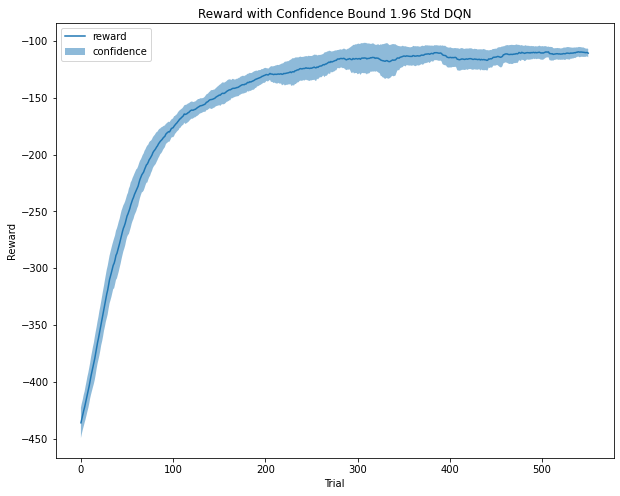

In [10]:
plot_multiple_agents(all_rewards,method)

### Video Of Last Agent

In [11]:
agent.best()
agent.video()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


### Rewards Of Last Agent

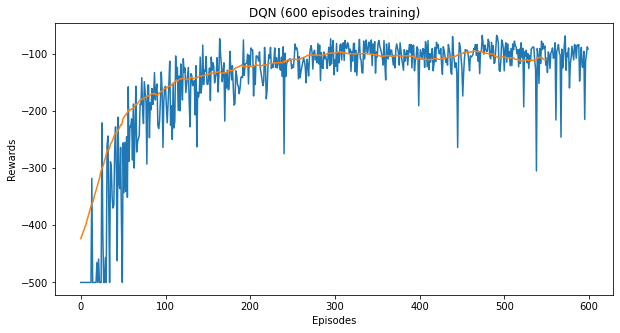

In [12]:
agent.plot(all_rewards[-1],method)

# Dueling Deep Q Network

In [13]:
method ='DDQN'
agent = Q_agent(state_dim,action_dim,method=method)

### Run for Multiple Agents

In [14]:
all_rewards = []
for i in range(10):
    one_agent_reward = run(agent,env,i)
    
    all_rewards.append(one_agent_reward)

agent number  1 
episode: 374 sum_of_rewards_for_episode: -108.0


KeyboardInterrupt: 

### Rewards With Confidence Bound

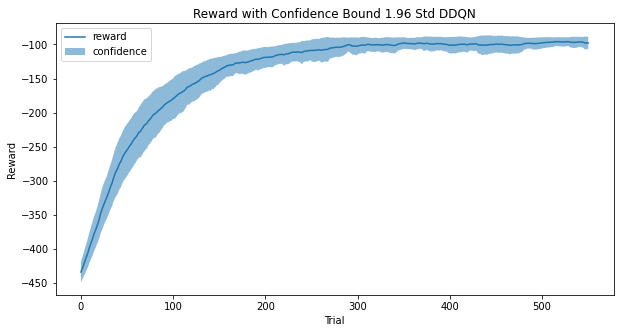

In [ ]:
plot_multiple_agents(all_rewards,method)

### Video of Last Agent

In [ ]:
agent.best()
agent.video()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


### Rewards of Last Agent

In [ ]:
agent.plot(all_rewards[-1],method)